# Airbnb Pricing Analysis

### Notebook By: Mike Li

# SUMMARY

## Project Goal

The goal of this project is to build a model to predict the rental prices of AirBNB listings based on various factors such as location, size, etc 

## Data Wrangling

1. Transform Date columns (host_since, first_review, last_review) to date Format

2. Transform dollar amount columns (price, weekly_price, monthly_price, security_deposit, cleaning_fee):
    a) removing $ and "," signs
    b) filling the empty dollar values with 0

3. Transform some columns with discrete values to type "category". These are property_type, room_type, bed_type, cancellation_policy

4. Run drop_duplicates() on dataframe to remove duplicates.

### Initial Review
1. Total Record Count: 7785<BR>
2. NULL Columns (ie with missing values):<BR>
|**Columns|Values Count**|<BR>
|bathrooms|7778|<BR>
|bedrooms|7784|<BR>
|square_feet|217|<BR>
|weekly_price|1302|<BR>
|monthly_price|1012|<BR>
|security_deposit|5563|<BR>
|cleaning_fee|6782|<BR>
|first_review|6724|<BR>
|last_review|6731|<BR>

## Exploratory Data Analysis (EDA)

**The analysis will mainly use these information:**
1. The rental configurations (property type, room type, bathrooms, bedrooms, square_feet, etc)
2. pricing (price, weekly_price, monthly_price, security_deposit, cleaning_fee) -> Discount (derived)
3. host's policy (guests_included, extra_people, minimum_nights, maximum_nights, cancellation_policy)
4. host (host_is_superhost)
5. Airbnb reviews (number_of_reviews,first_review, last_review)

# Actual Notebook

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#r_listings = pd.read_csv('sea_first100.csv', index_col='id');
r_listings_raw = pd.read_csv('sea_full.csv', index_col='id');

In [68]:
print(r_listings_raw.shape)
r_listings_raw.head(2)

(7785, 95)


,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,...,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,
2318,https://www.airbnb.com/rooms/2318,20180517031042,2018-05-17,"Casa Madrona - Urban Oasis, 1 block from the P...","Gorgeous, architect remodeled, 1917 Dutch Colo...","Casa Madrona is a gorgeous, architect remodele...","Gorgeous, architect remodeled, 1917 Dutch Colo...",none,NaN,"We adhere to a 10pm -9am quiet hour schedule, ...",...,f,NaN,{WASHINGTON},t,f,strict_14_with_grace_period,f,f,2,0.14
4291,https://www.airbnb.com/rooms/4291,20180517031042,2018-05-17,Sunrise in Seattle Master Suite,This property is located in the lovely Maple L...,"Located in Seattle, this is a spacious, clean ...",This property is located in the lovely Maple L...,none,NaN,NaN,...,f,NaN,{WASHINGTON},f,f,moderate,f,f,5,0.91


In [69]:
# TODO: General (Ref Unit 7.1.2 video)
# 1) What's the story?
# 2) What's memorable example of this? (ref: Linda the Bank Teller) (6/30)
# 3) What're more questions this will raise?
# 4a) Who is your audience? (but should be accessible to broadest audiences possible)
# 4b) What questions are you answering?
# 4c) Why should the audience care?
# 4d) What are your major insights and surprises? What change to you want to affect?

# 1) Story: Being an Airbnb host is not easy. Besides dealing with changing local 
#            regulations on the rental and uncertainty of renting out your house, 
#            the host also needs to ensure there is profit after incurring all the costs. 
# 4a) Audience: Airbnb hosts
# 4b) Questions Answering:
#     1) What drives price? Loc (eg Zips) or Configs (bed_type, room_type, property_type)    
# 4c) Why they care: Help them maximize profit by optimize the rental price, weekly and monthly prices


## Data Cleaning

### Initial Review: List columns with Null values

In [70]:
# Initial Review
# 1) List columns with Null values in file (use info() to identify)

required_data = ['property_type','room_type','accommodates',
'city', 'state', 'zipcode',
'bathrooms','bedrooms','beds',
'bed_type','square_feet','price',
'weekly_price','monthly_price','security_deposit',
'cleaning_fee','guests_included','extra_people',
'minimum_nights','maximum_nights','number_of_reviews', 'host_since',
'first_review','last_review','cancellation_policy']

r_listings = r_listings_raw[:][required_data]
print(r_listings.shape)
r_listings.info()

(7785, 25)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7785 entries, 2318 to 25133573
Data columns (total 25 columns):
property_type          7785 non-null object
room_type              7785 non-null object
accommodates           7785 non-null int64
city                   7785 non-null object
state                  7777 non-null object
zipcode                7714 non-null object
bathrooms              7778 non-null float64
bedrooms               7784 non-null float64
beds                   7785 non-null int64
bed_type               7785 non-null object
square_feet            217 non-null float64
price                  7785 non-null object
weekly_price           1302 non-null object
monthly_price          1012 non-null object
security_deposit       5563 non-null object
cleaning_fee           6782 non-null object
guests_included        7785 non-null int64
extra_people           7785 non-null object
minimum_nights         7785 non-null int64
maximum_nights         7785 non-null int6

### Initial Review: Visual review of Categorical Data (eg property/room/bed types) for bad values

In [71]:
# Review: Categories data
print("property_type")
print(r_listings['property_type'].value_counts(dropna=False))
print("\nroom_type")
print(r_listings['room_type'].value_counts(dropna=False))
print("\nbed_type")
print(r_listings['bed_type'].value_counts(dropna=False))

property_type
House                 2879
Apartment             2806
Townhouse              611
Guest suite            475
Condominium            340
Guesthouse             174
Serviced apartment      98
Loft                    94
Bungalow                85
Other                   43
Bed and breakfast       41
Cottage                 25
Boat                    21
Cabin                   19
Camper/RV               15
Houseboat               12
Tiny house              10
Hostel                   9
Tent                     7
Villa                    3
Castle                   3
Resort                   3
Boutique hotel           2
In-law                   2
Lighthouse               1
Nature lodge             1
Treehouse                1
Chalet                   1
Earth house              1
Yurt                     1
Farm stay                1
Hut                      1
Name: property_type, dtype: int64

room_type
Entire home/apt    5663
Private room       1967
Shared room         155
Name:

### Data Cleaning of Numeric Data

In [72]:
# Numeric Columns
# 1) Remove $ sign for columns 
# 2) Fill Null values with 0
# Ref: Cleaning Data (UNIT 5.1.4_ Using regular expressions to clean string)

def remove_sign(amt):
   amt = amt.replace('$', '').replace(',','')
   return(float(amt))

# TODO: 7/3/18:
# 1) just use groupby by zipcode to use mean(), etc. (Make sure blank is NaN and no String values)

# Fill null values with 0
r_listings['price'] = r_listings['price'].fillna('0') 
r_listings['weekly_price'] = r_listings['weekly_price'].fillna('0') 
r_listings['monthly_price'] = r_listings['monthly_price'].fillna('0') 
r_listings['security_deposit'] = r_listings['security_deposit'].fillna('0') 
r_listings['cleaning_fee'] = r_listings['cleaning_fee'].fillna('0') 

# Strip $ or "," signs from amt values
r_listings['price']  = r_listings['price'].apply(remove_sign)
r_listings['weekly_price']  = r_listings['weekly_price'].apply(remove_sign)
r_listings['monthly_price']  = r_listings['monthly_price'].apply(remove_sign)
r_listings['security_deposit']  = r_listings['security_deposit'].apply(remove_sign)
r_listings['cleaning_fee']  = r_listings['cleaning_fee'].apply(remove_sign)

### Visual review of Numeric Data for Outliers

In [73]:
# Review: Numeric data
print('Summary of price')
print(r_listings['price'].describe())

# print("\nMore Bathrooms than bedrooms")

Summary of price
count     7785.000000
mean       150.853821
std        255.345205
min          0.000000
25%         77.000000
50%        110.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64


### Cleaning and tidying datetime data

In [74]:
# Ref 5.1.1
# 6/26/18: Parse Date columns
r_listings['host_since'] = pd.to_datetime(r_listings['host_since'])
r_listings['first_review'] = pd.to_datetime(r_listings['first_review'])
r_listings['last_review'] = pd.to_datetime(r_listings['last_review'])

In [75]:
# TODO: Cleaning numeric data (Ref: 5.1.1)
# 1) Identify columns should be numeric, use dtypes() after load; if type is "object" -> non-numeric values in data
# 2) Use pd.to_numeric(), ref: "Cleaining Numberic column" exercise
#    a) Also Unit 5.1.4 start, use para errors='coerce' (turn bad values to "NaN")


### Transform Categorical Data

In [76]:
# TODO: Misc Cleaning (6/29/18)
# 0) Use count() to review columns that have NULL data
# 1) Identify columns that should be Categorical, then change the dtype
#    eg tips.smoker = tips.smoker.astype('category')
# 2) Identify columns with Missing Data
# 3) Run df.drop_duplicates() to ensure no dups
# 4) MIssing Data: If needed, (ref: Unit 5.1.4 chap4)
#    a) use tips_nan.dropna() to drop them or 
#    b) fillna() to fill them

# TODO (7/3/18): 
#    1) convert the type values to numeric values so modeling like random forest; etc
#    2) Linear Regression: Can't pass number; one hot encoding / dummy variables.

# 1) Identify columns that should be Categorical, then change the dtype
# columns: property_type, room_type, bed_type, cancellation_policy
r_listings['property_type'] = r_listings['property_type'].astype('category')
r_listings['room_type'] = r_listings['room_type'].astype('category')
r_listings['bed_type'] = r_listings['bed_type'].astype('category')
r_listings['cancellation_policy'] = r_listings['cancellation_policy'].astype('category')

r_listings.drop_duplicates() 
print("Dropped Duplicates")  # 7/24/18: drop_duplicates() somehow lists out whole dataframe

Dropped Duplicates


### Drop Outliers

#### Approach: 
1) Set a specific price point $2000 and listings above that price is considered outliers

In [77]:
# 8/3/18: Removed few outliers that are over $2000
r_cleaned = r_listings[r_listings['price'] <= 2000]
print(r_cleaned['price'].describe())

count    7779.000000
mean      144.697133
std       112.308384
min         0.000000
25%        77.000000
50%       110.000000
75%       175.000000
max      1750.000000
Name: price, dtype: float64


##   Exploratory Data Analysis (EDA) 

## Overview:
1) My audiences are the homeowners who are deciding 
* if they can make profit listing the house in AirBNB and 
* best listing price to optimize their profit while to ensure the unit will be leased in reasonable time.

2) The analysis will be based on the Supply-side data (AirBNB listings) at the moment to determine the right market price for a specific property

## The Questions:

### Question: How does number of listings correlate to listing prices?

#### Approach
1) Break down price ranges to 50 buckets<BR>
2) Build dataframe with num of listings vs average price under each price bucket<BR>
3) Plot a histogram with these data and try to identify correlations<BR>
4) Identify further questions from the analysis<BR>

#### Trend?
1) Listing prices are highly concentrated around the mean price around $150

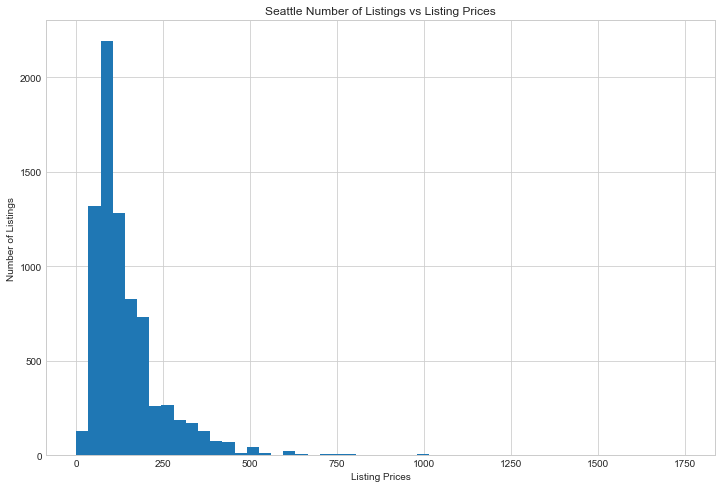

In [101]:
# ver1
list_prices = r_cleaned['price']

plt.rcParams["figure.figsize"] = [12, 8]
plt.hist(list_prices, bins = 50)
plt.title('Seattle Number of Listings vs Listing Prices')
plt.xlabel('Listing Prices')
plt.ylabel('Number of Listings')
plt.show()

### Question: How does locations (zipcode) correlate to listing prices?

#### Approach
1) Build dataframe with num of listings vs average price under each price bucket<BR>
2) Plot a Bar chart with these data and try to identify correlations<BR>
3) Identify further questions from the analysis<BR>

#### Trend? 
1) From the chart result, listing prices are in a narrow range except for a specific zip 98134

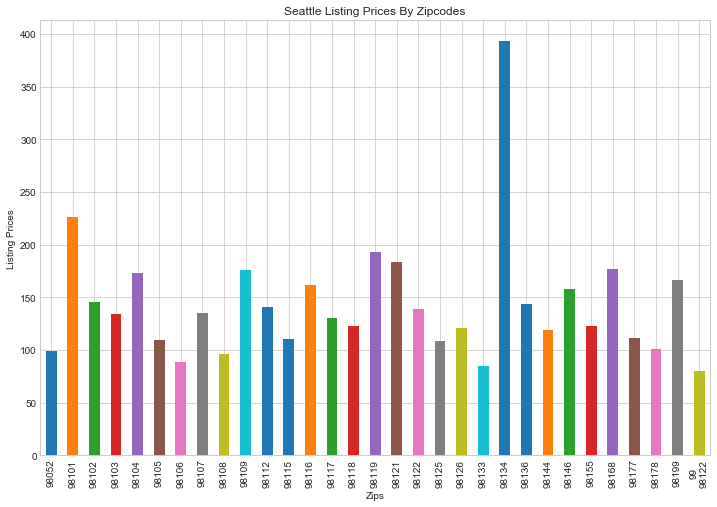

In [79]:
# ver2
price_by_zips = r_cleaned.groupby('zipcode').price.mean()
price_by_zips.plot(x='zipcode', kind='bar') 
plt.xlabel('Zips')
plt.ylabel('Listing Prices')
plt.title('Seattle Listing Prices By Zipcodes')
plt.show()

### Question: How does configurations (bathrooms, bedrooms, beds) correlate to listing prices?

#### Approach
1) Build dataframe with config_type vs the listing prices (broken in 10 price bucket)<BR>
2) Plot Scatterplots with these data and try to identify correlations (eg liner relationship)<BR>

#### Number of bedrooms and bathrooms

#### Trend? 
TBD

In [115]:
# ver1
# a) Y-axis: Number of listing; 
# b) X-axis: Break the price ranges to 10 buckets  (eg $0 - $100, $100-$200, $200-$300) and get Average price
# c) X-axis: 2 levels: Outer layer - Num of bedrooms; Inner Layer - Average Price in each bucket

# Ref: Unit 5.1.2: Hierarchical.. Index (for 2-level X-axis)
# eg. stocks = stocks.set_index(['Symbol', 'Date'])

#### Security Deposit and Cleaning Fee 

#### Trend? 
1) From the chart result, Security Deposit and Cleaning Fee don't seem to have impact on listing price

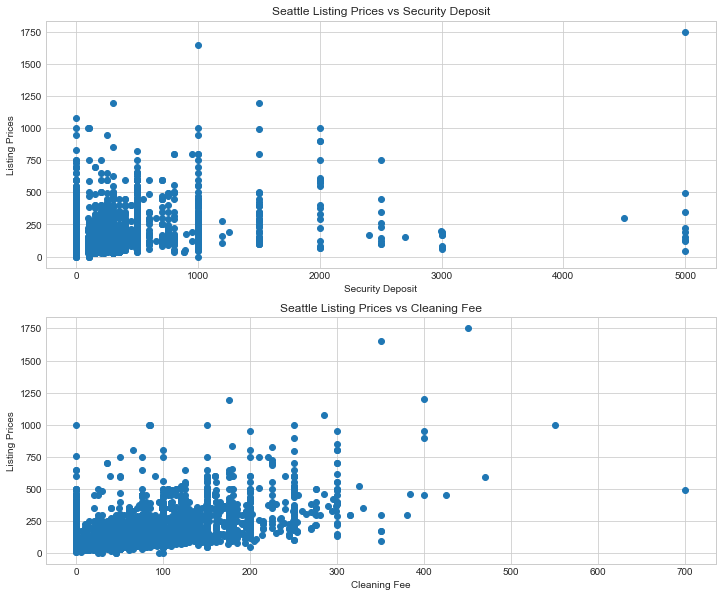

In [112]:
# ver1
list_prices = r_cleaned['price']

plt.rcParams["figure.figsize"] = [12, 10]
plt.subplot(2,1,1)
x_data = r_cleaned['security_deposit']
plt.xlabel('Security Deposit')
plt.ylabel('Listing Prices')
plt.title('Seattle Listing Prices vs Security Deposit')
plt.scatter(x_data, list_prices)

plt.subplot(2,1,2)
x_data = r_cleaned['cleaning_fee']
plt.xlabel('Cleaning Fee')
plt.ylabel('Listing Prices')
plt.title('Seattle Listing Prices vs Cleaning Fee')
plt.scatter(x_data, list_prices)

plt.show()

### Question: How does listing prices correlate to weekly and monthly prices (if applicable)? 
1) Want to identify if any discounts given on weekly or monthly price and if there is a certain pattern


#### Approach
TBD

## Guideline
Steps:
1. Ask the following questions and look for the answers using code and plots:<BR>
Can you count something interesting?<BR>
Can you find trends (e.g. high, low, increasing, decreasing, anomalies)?<BR>
Can you make a bar plot or a histogram?<BR>
Can you compare two related quantities?<BR>
Can you make a scatterplot?<BR>
Can you make a time-series plot?<BR>
    
2. Looking at the plots, what are some insights you can make? Do you see any correlations? Is there a hypothesis you’d like to investigate further? What other questions do the insights lead you to ask?

3. Now that you’ve asked questions, hopefully you’ve found some interesting insights. Is there a narrative or a way of presenting the insights using text and plots that tells a compelling story? What are some other trends/relationships you think will make the story more complete?

## The Notebook should contain:
1. The questions you asked
2. The trends you investigated
3. The resulting visualizations and conclusions

In [80]:
# TODO: Ensure Effective Visualizations (6/29/18)
# 1) Ensure not too crowded, clustered. (ref: 03-EDA.pdf)
# 2) Bad ones: spend time to read legions, think hard...
# 3) Good ones:
#   a) Have graphical integrity 2. Keep it simple
#   b) Use the right display
#   c) Use color strategically 5. Tell a story with data
# 4) Guidelines:
#   a) Bar chart: should start from 0; if smaller changes -> use other plots (dot plots)


In [81]:
# UNIT 8.5.1: Project: Capstone Project 1: Exploratory Data Analysis
# REQUIREMENTS:
# 1) Are there variables that are particularly significant in terms of explaining the answer to your project question?
# 2) Are there strong correlations between pairs of independent variables or between an independent and a dependent variable?
# 3) What are the most appropriate tests to use to analyse these relationships?

## ---------------
# 1) Variables: 
#    a) zipcode; bathroom, bedroom, square feet; types (property_type, room_type, bed_type) 
#    b) Prices (price, weekly, monthly); 
#    c) cancellation_policy, security_deposit, cleaning_fee


In [82]:
# TODOs: 7/1/18:
# 1) Hist: Y:Zip, X:Avg Price by ZiP
# 1b) Hist: above but break down by bed_type, room_type
# 2) Plotter: similar set 
# TBD: Watch out for outliers

# References:
# 1) Art of Effective Visualization of Multi-dimensional Data
#   URL: https://towardsdatascience.com/the-art-of-effective-visualization-of-multi-dimensional-data-6c7202990c57

In [83]:
# CHART: ScatterPlots: x: num of bedrooms, y: price
# Conclusion: 1) NO correlation between Number of Bedrooms vs Prices
# 7/7/18: Mentor suggests to use Histogram instead.

# TODOs/QUESTIONS:
# 1) How to plot 2 groups on 2 room types (Entire home/apt vs Private room)
# 2) What to do with few outliners that expand prices scale from 2000 or more?

# Misc Notes:
# a) r_listings['bedrooms']: type is Pandas Series
# b) Needed to ensure prices is numeric so will be shown in order

# 7/2/18: Control size of the in-line charts
# plt.rcParams['figure.figsize'] = [15, 15]

# TODOs: 7/3/18 (after mentor call)
# 1) Use sns.FacetGrid, put 2 diff colors (Use DJ's article on Visualization)
#   a) search for "fig.suptitle('Wine Type - Alcohol - Quality - Acidity', fontsize=14)"
#   b) "jp = sns.pairplot(wines, x_vars=["sulphates"], y_vars=["alcohol"], size=4.5,"

# plt.scatter(r_listings['bedrooms'], r_listings['price']) # scatter
# plt.title('Number of Bedrooms vs Prices')
# plt.xlabel('Num of Bedrooms')
# plt.ylabel('Prices')
# plt.show()

In [84]:
# CHART: Histogram: (7/7/18)
# a) Y-axis: Number of listing; 
# b) X-axis: Break the price ranges to 10 buckets  (eg $0 - $100, $100-$200, $200-$300) and get Average price
# c) X-axis: 2 levels: Outer layer - Num of bedrooms; Inner Layer - Average Price in each bucket

# Ref: Unit 5.1.2: Hierarchical.. Index (for 2-level X-axis)
# eg. stocks = stocks.set_index(['Symbol', 'Date'])

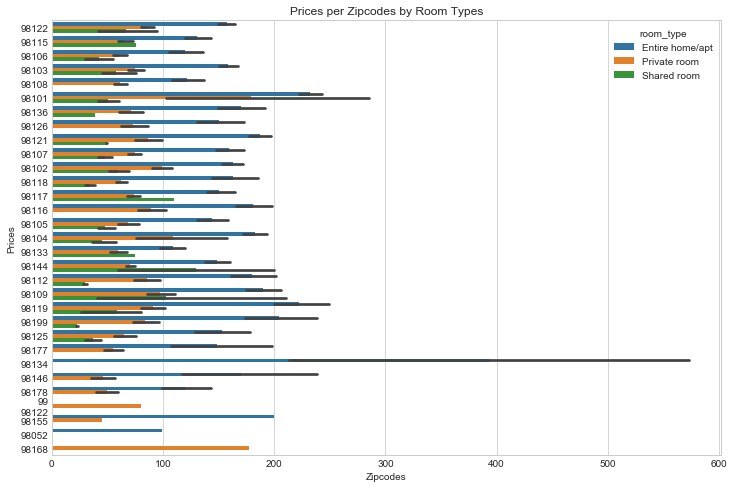

In [103]:
# CHART: Bar Chart1 
# C1: Hist: Y:Zip, X:Avg Price by ZiP
# C2: Hist: Y:Zip, X:Avg Price by ZiP but break down by bed_type, room_type, property_type

# Conclusion: TBD

# TODOs/QUESTIONS:
# 1) 7/3/18: too hard to see all zip codes. Any suggestions?
# 2) 7/5/18: How do I sort the zipcodes?

# NOTES: 7/7/18
# 1) Set zipcodes as Index and use sort_index() so appear sorted (Unit 5.1.2)

# NOTES: 7/3/18 (after mentor call)
# 2) (Test) use func (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.melt.html)
# 3) Use Seaborn (https://seaborn.pydata.org/generated/seaborn.barplot.html)
# 4) When I have zipcode on Y-axis, it's harder to see whole chart but easier to see the zipcode
sns.set_style("whitegrid")
ax = sns.barplot(y="zipcode", x="price", hue="room_type", data=r_cleaned) # break down by room_types
#ax = sns.barplot(y="price", x="zipcode", data=r_listings) # work1
plt.rcParams["figure.figsize"] = [20, 16]
plt.title('Prices per Zipcodes by Room Types')
plt.xlabel('Zipcodes')
plt.ylabel('Prices')
plt.show()


# NOTES: 7/3/18: Histogram is for continus values but by zipcodes in here is discrete so WRONG chart type to use. 

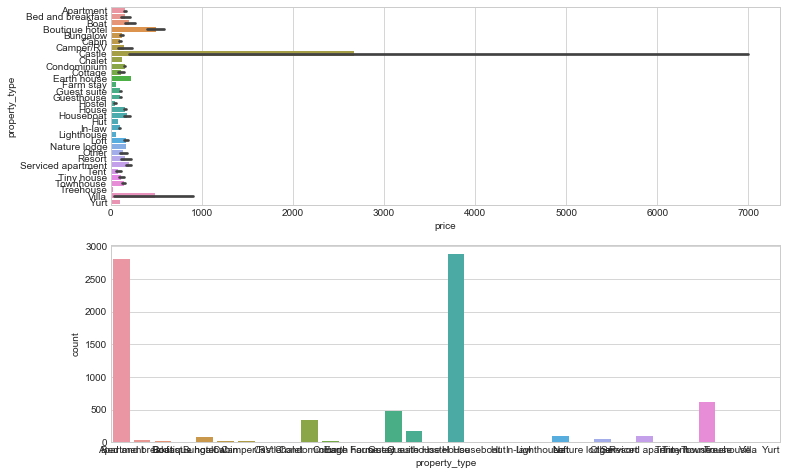

In [86]:
# CHART: Bar Chart 2

# TODO/Questions: 7/5/18
# 1) Suggestions: Many property types make it hard to read and crowded, other ways?
# 2) Outliers: Castle, how to address?

plt.subplot(2,1,1) # Grid row, Grid, column, current subplot 
sns.set_style("whitegrid")
price_by_type = sns.barplot(y="property_type", x="price", data=r_listings) # break down by room_types

plt.subplot(2,1,2)
sns.set_style("whitegrid")
cnt_by_type = sns.countplot(x="property_type", data=r_listings) 
plt.show()

# TODOs: 7/3/18 (after mentor call)
# 1) Try to use Bar plot instead, only use Pie chart for few categories

In [87]:
# CHART: Histogram 1 
# 1) X - price per square foot, Y - count (ref: UNIT 10.1.2 NY Housing) (7/5/18)
# 2) Take a log() to see difference

In [88]:
# CHART: Pearson Correlation
# TODOs: 7/3/18 (after mentor call)
#  1) https://seaborn.pydata.org/generated/seaborn.heatmap.html (Example at end of page)
#  2) Check https://seaborn.pydata.org/examples/many_pairwise_correlations.html

# SAMPLE: Pearson Correlation
# corr = np.corrcoef(np.random.randn(10, 200))
# mask = np.zeros_like(corr)
# mask[np.triu_indices_from(mask)] = True
# with sns.axes_style("white"):
#      ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True)

In [89]:
##  =================== Features Engineering ===================

In [90]:
# TODOs: (as of 7/5/18)
# 1) Assign ranking based on bed_type, room_type and property_type? (7/1/18)
# 2) Price/Sq foot, only consider price is meaningless (7/5/18)

In [91]:
# TODO: Machine Learning (6/30/18) (Unit 10.1)
# 1) Any bias in data? Eg from un-collected data

In [92]:
##  =================== Modeling ===================

In [93]:
## References:
# 1) UNIT 10.1.2: NY Housing Example 
#    a) Use value/sq foot

In [94]:
## Model1: Linear Regressions

In [95]:
## Model2: K-nearest neighbors

In [96]:
# QUESTIONS (7/3/18):
# 3) K-nearest neighbors: 
#     a) Is using Num of bedrooms make most sense?
#     b) OR better to use ZIP, prop_type, etc? How to determine best attribute?